Fit surface to data, for a combination of ATM ICESSN data and ICESat-2 data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pointCollection as pc
import os
import h5py
import sparseqr
import LSsurf

plt.rcParams['animation.ffmpeg_path'] = os.path.join(os.environ['CONDA_PREFIX'],'bin','ffmpeg')

In [2]:
datafile1 = '/home/jovyan/shared-public/off_track/Sierra/ATM/collected_ICESSN.h5'            #file of ATM ICESSN data
datafile2 = '/home/jovyan/ICESat-2_hackweek/off_track/shared/staged_data/ATL06_helheim.h5'   #file of ATLO6 ICESat-2 data
D = pc.data().from_list([pc.data().from_h5(datafile1, group='/'), pc.data().from_h5(datafile2, group='/')])
print(D)

<class 'pointCollection.data.data'> with shape (207910,),
with fields:
['sigma', 't', 'x', 'y', 'z', 'cycle', 'gt', 'rgt', 'spot']


In [3]:
# Compute span and center of x and y coordinates to be used later to determine span and center of reconstructed grid.
x_max = 310000
x_min = 310000-20000
x_cen = (x_min + x_max)/2
x_span = x_max - x_min
y_cen = -2575000

y_max = y_cen +1.e4
y_min = y_cen -1.e4
y_span = y_max - y_min

print('Span x: ' + str(x_span))
print('Center x: ' + str(x_cen))
print('Span y: ' + str(y_span))
print('Center y: ' + str(y_cen))

# Convert t from seconds since 1 Jan 2018 to decimal years 

# Compute span and center of t
t_min = np.nanmin(D.t)
t_max = np.nanmax(D.t)
t_cen = round(4*(t_min + t_max)/2)/4
t_span = t_max - t_min
print('Span t: ' + str(t_span))
print('Center t: ' + str(t_cen))



Span x: 20000
Center x: 300000.0
Span y: 20000.0
Center y: -2575000
Span t: 10.048377443498566
Center t: 2019.25


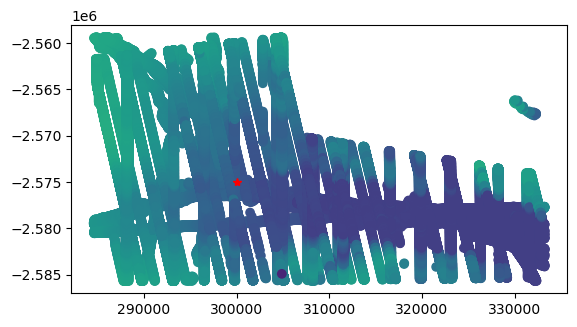

In [4]:
plt.figure()
plt.scatter(D.x, D.y, c=D.z)
plt.gca().set_aspect(1)
plt.plot(x_cen, y_cen,'r*')

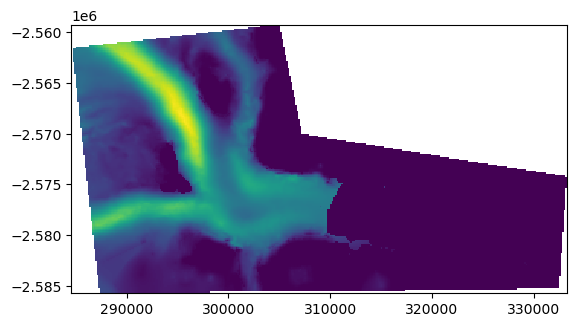

In [5]:
thicknessmap = pc.grid.data().from_geotif('/home/jovyan/shared-public/off_track/Sierra/ice_thickness_helheim_clipped2.tif')
plt.figure()
thicknessmap.show()

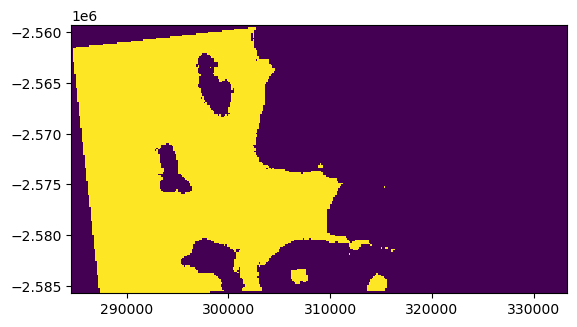

In [6]:
mask=pc.grid.data().from_dict({'x':thicknessmap.x,'y':thicknessmap.y,'z':thicknessmap.z>50})
plt.figure()
mask.show()

In [34]:
from LSsurf.smooth_fit import smooth_fit

E_d3zdx2dt=0.00001 # d/dt of the el diff map curvature
E_d2z0dx2=0.06 # 2nd diff of base el map
E_d2zdt2=5000 # Second time deriv of el diff.

data=D.copy()
#data.assign({'sigma':np.zeros_like(data.z)+0.1})
print(data)

ctr={'x':x_cen,'y':y_cen,'t':t_cen} 
print(ctr)
W={'x':2e4,'y':2e4,'t':8} # Numbers should span whats in data. Units don't matter. 
print(W)
spacing={'z0':100, 'dz':500, 'dt':0.25} # z0 is elevation spacing, dz is el. diff spacing, dt is temporal spacing between el. diff surfaces

data_gap_scale=2500
E_RMS={'d2z0_dx2':E_d2z0dx2, 'dz0_dx':E_d2z0dx2*data_gap_scale, 'd3z_dx2dt':E_d3zdx2dt, 'd2z_dxdt':E_d3zdx2dt*data_gap_scale,  'd2z_dt2':E_d2zdt2}

<class 'pointCollection.data.data'> with shape (207910,),
with fields:
['sigma', 't', 'x', 'y', 'z', 'cycle', 'gt', 'rgt', 'spot']
{'x': 300000.0, 'y': -2575000, 't': 2019.25}
{'x': 20000.0, 'y': 20000.0, 't': 8}


In [35]:
# run the fit
S=smooth_fit(data=data, ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
             reference_epoch=5, compute_E=False,
             max_iterations=5, mask_data=mask, mask_scale={0:10, 1:1},
             VERBOSE=True, dzdt_lags=[1])
dz=S['m']['dz']
z0=S['m']['z0']
dz.t=dz.time
dz.cell_area=np.tile(dz.cell_area[:,:,None], [1,1, len(dz.t)])

smooth_fit: E_RMS={'d2z0_dx2': 0.06, 'dz0_dx': 150.0, 'd3z_dx2dt': 1e-05, 'd2z_dxdt': 0.025, 'd2z_dt2': 5000}
initial: 56201:
starting qr solve for iteration 0 at Thu Aug 22 23:13:36 2024
found 50237 in TSE, dt=113
	 median(sigma_extra)=2.9793
starting qr solve for iteration 1 at Thu Aug 22 23:15:29 2024
found 47762 in TSE, dt=138
	 median(sigma_extra)=2.0195
starting qr solve for iteration 2 at Thu Aug 22 23:17:47 2024
found 46372 in TSE, dt=129
	 median(sigma_extra)=1.7202
starting qr solve for iteration 3 at Thu Aug 22 23:19:56 2024
found 45503 in TSE, dt=131
	 median(sigma_extra)=1.5790
starting qr solve for iteration 4 at Thu Aug 22 23:22:07 2024


In [36]:
z0=S['m']['z0']


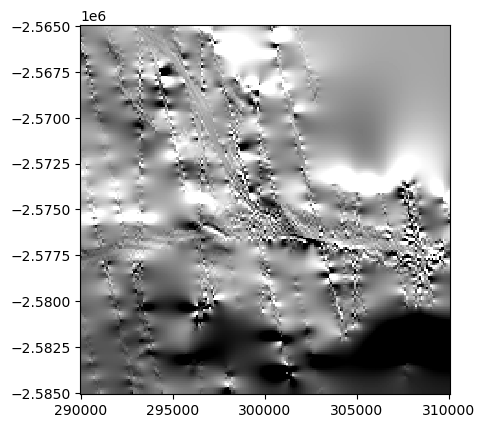

In [37]:


z0.show(gradient=True, field='z0', origin='lower', extent = z0.extent)

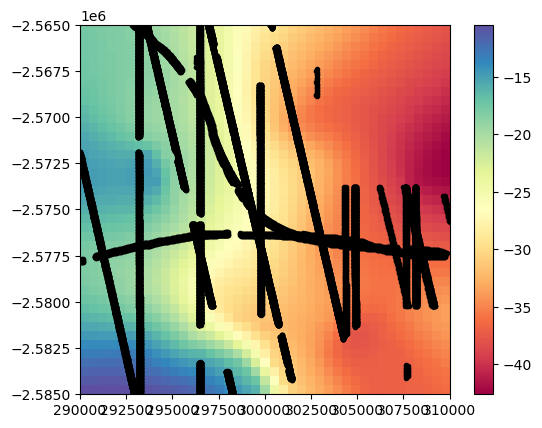

In [53]:
dz=S['m']['dz']
plt.imshow(dz.dz[:,:,32]-dz.dz[:,:,15], origin='lower', extent = dz.extent, cmap='Spectral')
plt.colorbar()
data1=S['data'][S['data'].t > 2019]
plt.plot(data1.x, data1.y,'k.')

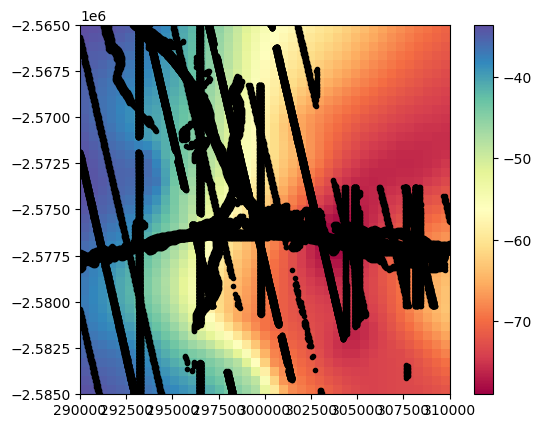

In [54]:
dz=S['m']['dz']
plt.imshow(dz.dz[:,:,32]-dz.dz[:,:,1], origin='lower', extent = dz.extent, cmap='Spectral')
plt.colorbar()
data1=S['data']
plt.plot(data1.x, data1.y,'k.')

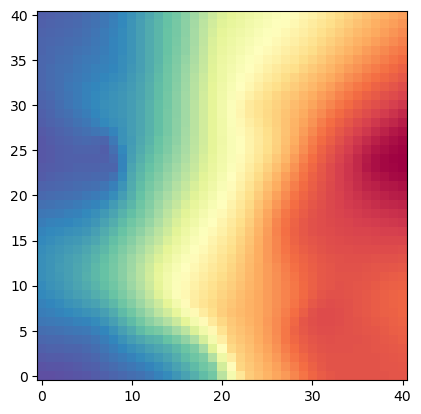

In [40]:
plt.imshow(dz.dz[:,:,-1]-dz.dz[:,:,11], origin='lower', cmap='Spectral')

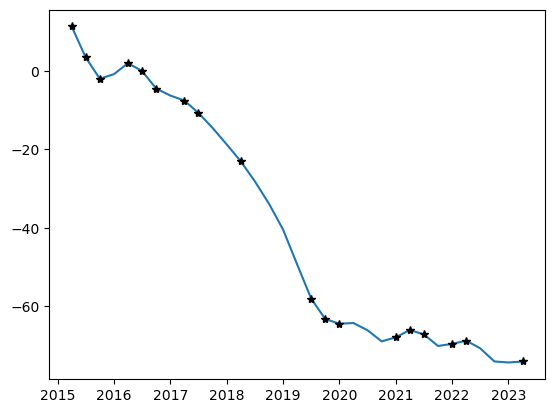

In [43]:
plt.figure()
plt.plot(dz.t, dz.dz[17,26, :])
jj = dz.count[17,26,:]>2
plt.plot(dz.t[jj], dz.dz[17,26, jj],'k*')

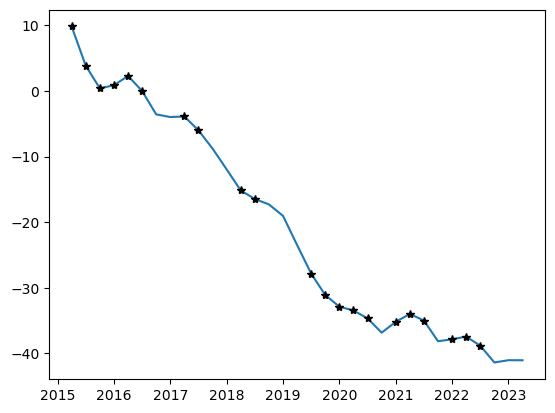

In [51]:
plt.figure()
plt.plot(dz.t, dz.dz[32,13, :])
jj = dz.count[32,13,:]>2
plt.plot(dz.t[jj], dz.dz[32,13, jj],'k*')

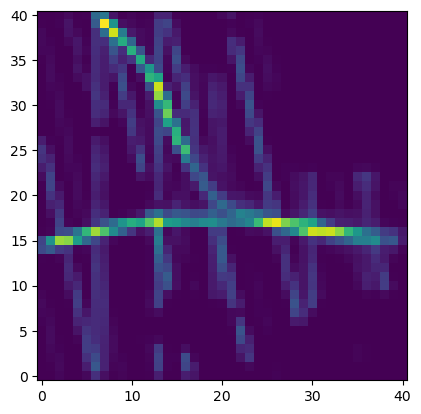

In [44]:
plt.imshow(np.nansum(dz.count[:,:,:],axis=2), origin='lower')

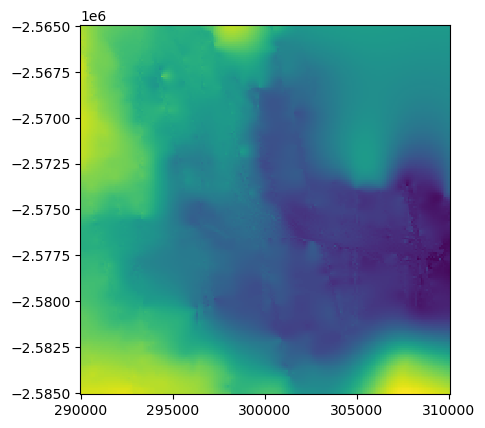

In [45]:
plt.figure()
z0.show(field='z0')

In [22]:
bds=[*map(np.array, z0.bounds())]
import shapely

temp=shapely.Polygon(np.c_[bds[0][[0, 0, 1, 1, 0]], bds[1][[0, 1, 1, 0, 0]]])

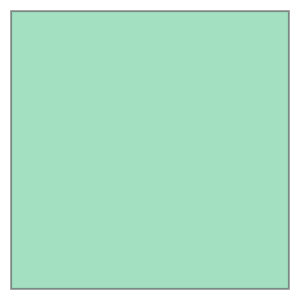

In [23]:
temp

In [40]:
with open('helheim_domain.geojson','w') as fh:
    fh.write(shapely.to_geojson(temp))

In [41]:
! cat helheim_domain.geojson

{"type":"Polygon","coordinates":[[[290000.0,-2585000.0],[290000.0,-2565000.0],[310000.0,-2565000.0],[310000.0,-2585000.0],[290000.0,-2585000.0]]]}

In [43]:
! pwd

/home/jovyan/shared-public/off_track/Sierra


In [52]:
dz.t

array([2015.25, 2015.5 , 2015.75, 2016.  , 2016.25, 2016.5 , 2016.75,
       2017.  , 2017.25, 2017.5 , 2017.75, 2018.  , 2018.25, 2018.5 ,
       2018.75, 2019.  , 2019.25, 2019.5 , 2019.75, 2020.  , 2020.25,
       2020.5 , 2020.75, 2021.  , 2021.25, 2021.5 , 2021.75, 2022.  ,
       2022.25, 2022.5 , 2022.75, 2023.  , 2023.25])

In [28]:
t_max

2024.3250897722658

In [33]:
t_min

2014.2767123287672

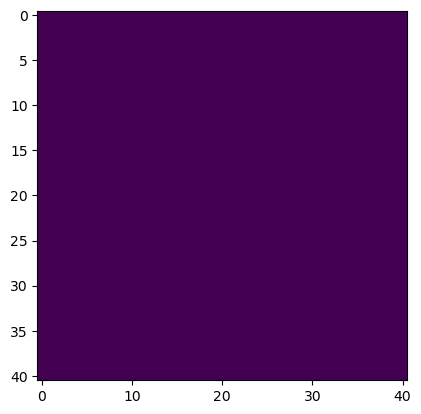

In [56]:
plt.figure()
plt.imshow(
    np.any(dz.cell_area, axis=2))